In [1]:
!pip install pystan
!pip install fbprophet
!pip install pmdarima

In [2]:
#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [6]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [7]:
figure = px.line(data_DMA225,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [8]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')
hourly_data = data_DMA225_indexed.resample('h').sum()

# Stationarity check

In [9]:
#Statistical information
hourly_data.describe()

,DMA_225
count,8760.000000
mean,14.605825
std,9.939253
min,0.000000
25%,8.001000
50%,13.888000
75%,19.444000
max,237.554001


<Figure size 1584x720 with 0 Axes>

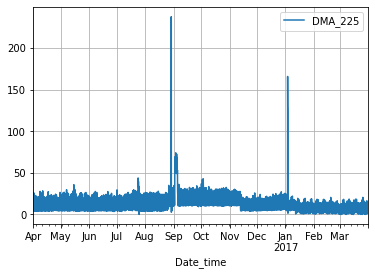

<Figure size 1584x720 with 0 Axes>

In [10]:
# Looking at plots
DMA225_df_indexed = hourly_data[['DMA_225']]
DMA225_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [11]:

# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.013940
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -7. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [12]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1999: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(3.779446633738152,
 0.01,
 45,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation :

1.The ADF statistic value of 3.77. The positive value is statistic, and hence we have a stationary dataset.



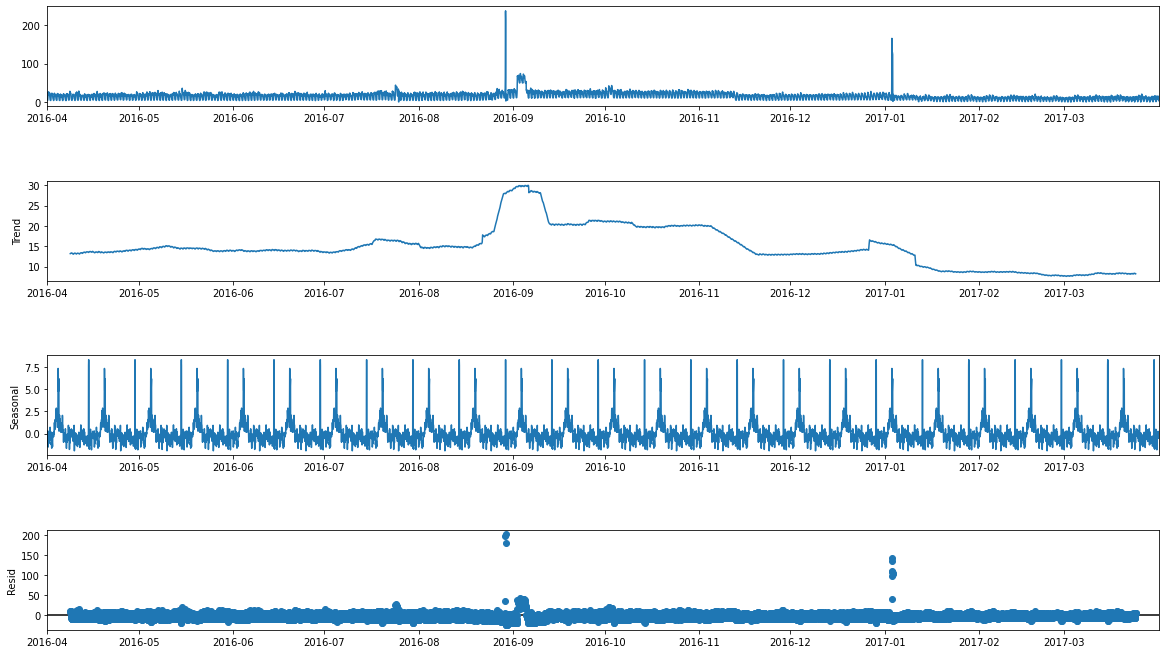

In [13]:
res=sm.tsa.seasonal_decompose(hourly_data,period=365)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

In [14]:
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(8760, 2)

In [15]:
#general Information
data_DMA225_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2016-04-01 00:00:00 to 2017-03-31 23:45:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DMA_225  35032 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


In [16]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(8760, 2)

In [17]:
#Train and test split
split = 1059
train = hourly_data_index[:-1059]
test = hourly_data_index[-1059:]

In [18]:
train.shape

(7701, 2)

In [19]:
test.shape

(1059, 2)

In [20]:
#Instatntiate model
model = Prophet()
#Train
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [21]:
future = model.make_future_dataframe(periods=1059,freq = '1H')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8755,2017-03-31 19:00:00,5.708926,-18.555370,28.427825
8756,2017-03-31 20:00:00,3.026357,-18.707491,27.247809
8757,2017-03-31 21:00:00,0.174628,-22.490526,23.973675
8758,2017-03-31 22:00:00,-2.148795,-25.810796,21.912427
8759,2017-03-31 23:00:00,-3.690313,-26.165991,19.898125


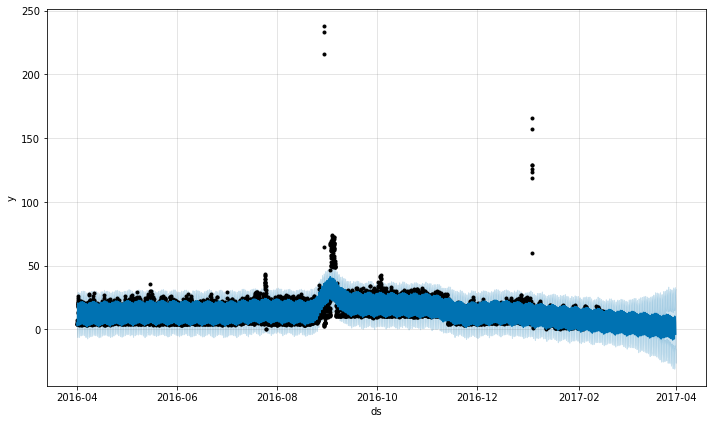

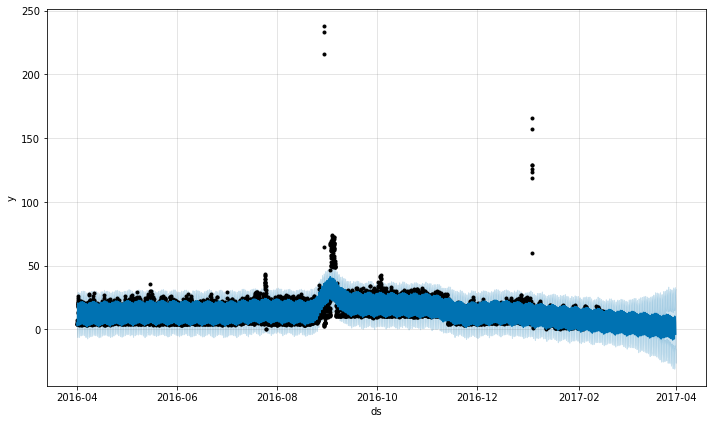

In [22]:
model.plot(forecast)

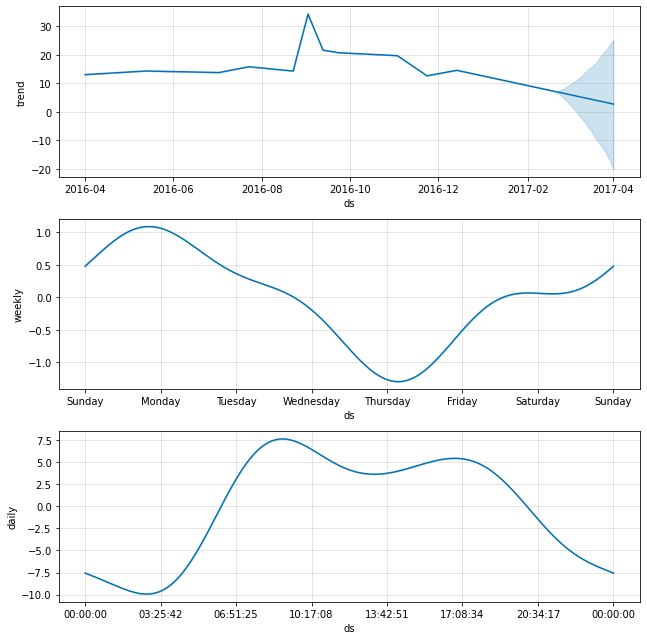

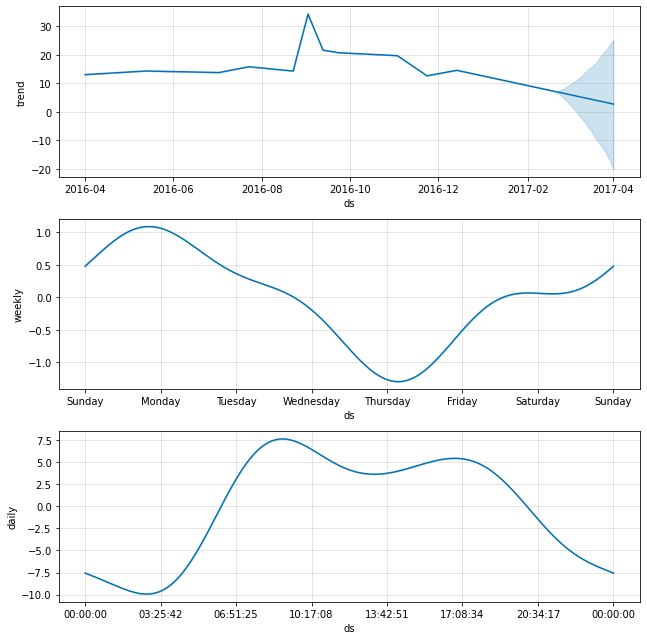

In [23]:
model.plot_components(forecast)

In [31]:
forecast.shape

(8760, 19)

In [34]:
forecast.yhat[-1060:]

7700    6.622505
7701    3.737677
7702    1.386488
7703   -0.177544
7704   -1.251882
          ...   
8755    5.708926
8756    3.026357
8757    0.174628
8758   -2.148795
8759   -3.690313
Name: yhat, Length: 1060, dtype: float64

In [25]:
pred = forecast[['ds', 'yhat']]
pred = pred[-1059:]
pred

,ds,yhat
7701,2017-02-15 21:00:00,3.737677
7702,2017-02-15 22:00:00,1.386488
7703,2017-02-15 23:00:00,-0.177544
7704,2017-02-16 00:00:00,-1.251882
7705,2017-02-16 01:00:00,-2.287357
...,...,...
8755,2017-03-31 19:00:00,5.708926
8756,2017-03-31 20:00:00,3.026357
8757,2017-03-31 21:00:00,0.174628
8758,2017-03-31 22:00:00,-2.148795


In [26]:
test.head(2)

,ds,y
7701,2017-02-15 21:00:00,7.334
7702,2017-02-15 22:00:00,7.111


In [35]:
# Making final df of original and predicted value
#fp = forecast_prediction[['ds', 'yhat']]
fd1=pd.merge(test, pred, on="ds")
fd1

,ds,y,yhat
0,2017-02-15 21:00:00,7.334,3.737677
1,2017-02-15 22:00:00,7.111,1.386488
2,2017-02-15 23:00:00,5.333,-0.177544
3,2017-02-16 00:00:00,2.778,-1.251882
4,2017-02-16 01:00:00,1.332,-2.287357
...,...,...,...
1054,2017-03-31 19:00:00,10.888,5.708926
1055,2017-03-31 20:00:00,7.223,3.026357
1056,2017-03-31 21:00:00,7.222,0.174628
1057,2017-03-31 22:00:00,4.999,-2.148795


In [36]:
#Calculate rmse
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(fd1.y,fd1.yhat))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  4.227


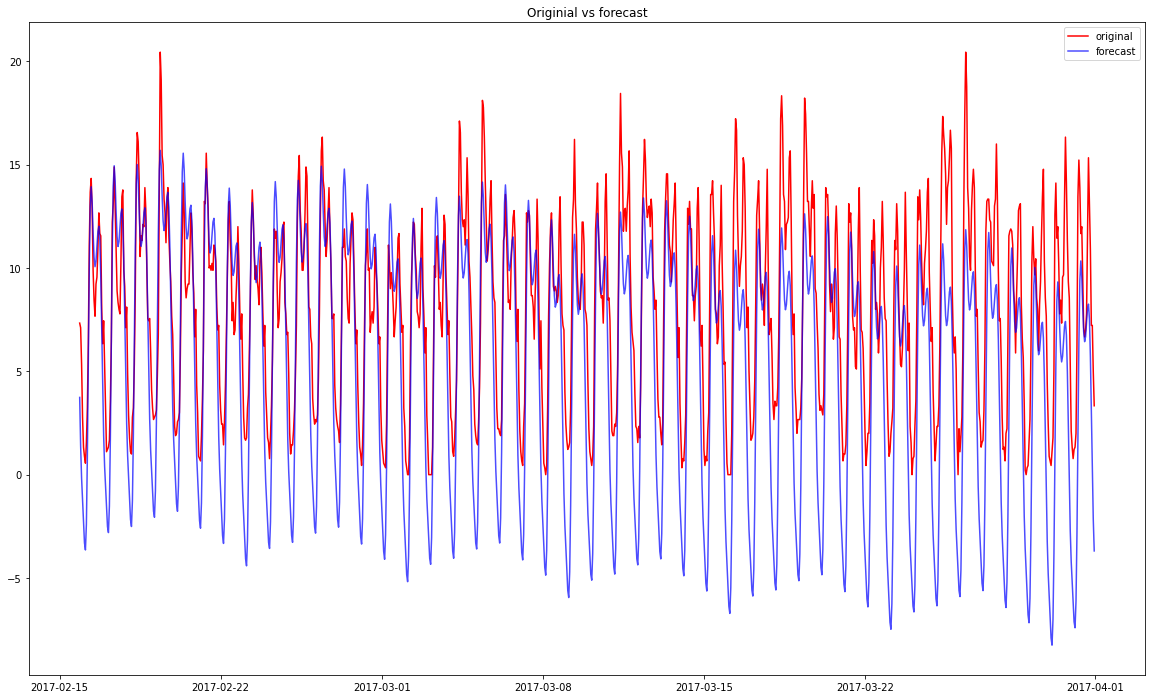

In [37]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd1.ds, fd1.y, color='red', label='original')
plt.plot(fd1.ds, fd1.yhat, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()